In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from TreeUtils.graph import BiGraph
from TreeUtils.core.data_helper import DataHelper
import pydotplus
import numpy as np
import pandas as pd
import lightgbm as lgb
from IPython.display import HTML, Image

In [2]:
n = 1000
p = 5
X, y = make_classification(n_samples=n, n_features=p, n_informative=int(p/2), n_redundant=0, n_repeated=0, n_classes=3, n_clusters_per_class=1, random_state=55)
feature_name = [f'X{i}' for i in range(X.shape[1])]

X = pd.DataFrame(X, columns=feature_name, dtype='float')
X = pd.concat([X, 
               pd.Series(np.random.choice(list('ABCDEFG'), X.shape[0]), dtype='category', name=f'X{p+1}'),
              pd.Series(np.random.choice(list('PQRSTUVWX'), X.shape[0]), dtype='category', name=f'X{p+2}')],
             axis=1)

feature_name = list(X.columns.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X.head()

,X0,X1,X2,X3,X4,X6,X7
0,0.096550,-0.747123,-0.720515,0.492136,0.933614,G,R
1,2.325813,0.887953,-0.448051,-1.261140,-0.168818,D,S
2,1.638533,-0.591523,0.918613,-1.403862,-0.190640,C,X
3,0.900679,0.734327,-0.383572,-0.055029,-0.172669,C,P
4,-0.763597,-0.769214,0.254625,0.595658,-0.809154,D,W


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
X0    1000 non-null float64
X1    1000 non-null float64
X2    1000 non-null float64
X3    1000 non-null float64
X4    1000 non-null float64
X6    1000 non-null category
X7    1000 non-null category
dtypes: category(2), float64(5)
memory usage: 41.9 KB


In [4]:
X['X6'].cat.codes.head()

0    6
1    3
2    2
3    2
4    3
dtype: int8

In [5]:
X['X6'].cat.set_categories(list('ACBDEFG')).cat.codes.head()

0    6
1    3
2    1
3    1
4    3
dtype: int8

In [6]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)
print(feature_name)

['X0', 'X1', 'X2', 'X3', 'X4', 'X6', 'X7']


In [7]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_leaves': 5,
    'num_class':3,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

gbm = lgb.train(params, lgb_train, num_boost_round=5, valid_sets=lgb_test, feature_name=feature_name)

[1]	valid_0's multi_logloss: 1.07179
[2]	valid_0's multi_logloss: 1.04268
[3]	valid_0's multi_logloss: 1.00136
[4]	valid_0's multi_logloss: 0.971506
[5]	valid_0's multi_logloss: 0.943673


In [8]:
gbm.dump_model().keys()

dict_keys(['name', 'version', 'num_class', 'num_tree_per_iteration', 'label_index', 'max_feature_idx', 'average_output', 'objective', 'feature_names', 'monotone_constraints', 'tree_info', 'pandas_categorical'])

In [9]:
gbm.dump_model()

{'name': 'tree',
 'version': 'v3',
 'num_class': 3,
 'num_tree_per_iteration': 3,
 'label_index': 0,
 'max_feature_idx': 6,
 'average_output': False,
 'objective': 'multiclass num_class:3',
 'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X6', 'X7'],
 'monotone_constraints': [],
 'tree_info': [{'tree_index': 0,
   'num_leaves': 5,
   'num_cat': 0,
   'shrinkage': 1,
   'tree_structure': {'split_index': 0,
    'split_feature': 0,
    'split_gain': 203.05099487304688,
    'threshold': -0.20247610315478412,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 0,
    'internal_weight': 0,
    'internal_count': 600,
    'left_child': {'split_index': 1,
     'split_feature': 4,
     'split_gain': 13.511500358581543,
     'threshold': -2.114846856189076,
     'decision_type': '<=',
     'default_left': True,
     'missing_type': 'None',
     'internal_value': 1.09098,
     'internal_weight': 104.207,
     'internal_count': 234,
     'left_chi

In [10]:
gbm.dump_model()['pandas_categorical'][0]

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [11]:
# gbm.dump_model()['tree_info'][0]['tree_structure']

In [2]:
n = 50000
p = 100
X, y = make_classification(n_samples=n, n_features=p, n_informative=int(p/2), n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=4, random_state=55)
feature_name = [f'X{i}' for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


clf = DecisionTreeClassifier(min_samples_split=2000, max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [3]:
reg_tree = DecisionTreeRegressor(min_samples_split=10000, max_depth=2)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10000,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [4]:
graph = BiGraph.from_sklearn_tree(clf)
display(graph.get_graph_info())

{'_fitted': True,
 '_internally_fitted': False,
 'objective': 'classification',
 'n_class': 2,
 'class_name': array([0, 1]),
 'features_name': None,
 'score_data': {'pred_score_key': 'value', 'color_score_key': 'value'},
 'n_features': 100}

In [5]:
HTML(graph.df.to_html())

,depth,parent,child_left,child_right,type,data,score
0,0,0,1,2,0,"{'feature_data': {'split_feature': 12, 'split_criteria': '<=', 'split_threshold': -2.0825871229171753}}","{'gini': 0.4999999943111111, 'sample': 37500, 'value': [0.5000533333333333, 0.49994666666666665]}"
1,1,0,3,4,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -1.3576117753982544}}","{'gini': 0.4768391903696647, 'sample': 12401, 'value': [0.6076122893315056, 0.3923877106684945]}"
2,1,0,9,10,1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 0.9673941433429718}}","{'gini': 0.4943629538037777, 'sample': 25099, 'value': [0.4469102354675485, 0.5530897645324515]}"
3,2,1,5,6,-1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 3.68274986743927}}","{'gini': 0.3953342751715758, 'sample': 4085, 'value': [0.7287637698898409, 0.2712362301101591]}"
4,2,1,7,8,1,"{'feature_data': {'split_feature': 9, 'split_criteria': '<=', 'split_threshold': -0.6838884949684143}}","{'gini': 0.4953727707455461, 'sample': 8316, 'value': [0.5481000481000481, 0.4518999518999519]}"
5,3,3,-1,-1,-1,{'feature_data': None},"{'gini': 0.3395860090944033, 'sample': 3335, 'value': [0.783208395802099, 0.21679160419790106]}"
6,3,3,-1,-1,1,{'feature_data': None},"{'gini': 0.49964444444444445, 'sample': 750, 'value': [0.4866666666666667, 0.5133333333333333]}"
7,3,4,-1,-1,-1,{'feature_data': None},"{'gini': 0.4578563995837669, 'sample': 3565, 'value': [0.6451612903225806, 0.3548387096774194]}"
8,3,4,-1,-1,1,{'feature_data': None},"{'gini': 0.4987766924164144, 'sample': 4751, 'value': [0.47526836455483057, 0.5247316354451694]}"
9,2,2,11,12,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -0.6225283443927765}}","{'gini': 0.49893471319709315, 'sample': 14342, 'value': [0.5230790684702273, 0.4769209315297727]}"


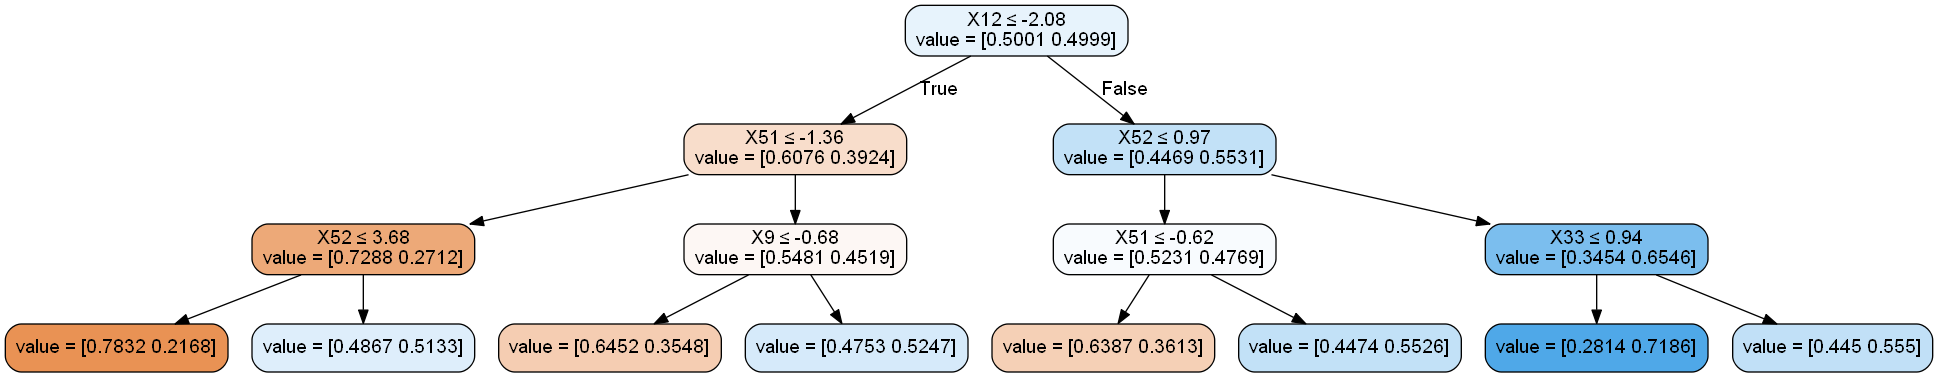

In [6]:
Image(graph.create_png(features_name=feature_name))

In [7]:
graph2 = BiGraph.from_sklearn_tree(clf)
graph2.df.loc[0, 'score'] = None
HTML(graph2.df.to_html())

,depth,parent,child_left,child_right,type,data,score
0,0,0,1,2,0,"{'feature_data': {'split_feature': 12, 'split_criteria': '<=', 'split_threshold': -2.0825871229171753}}",None
1,1,0,3,4,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -1.3576117753982544}}","{'gini': 0.4768391903696647, 'sample': 12401, 'value': [0.6076122893315056, 0.3923877106684945]}"
2,1,0,9,10,1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 0.9673941433429718}}","{'gini': 0.4943629538037777, 'sample': 25099, 'value': [0.4469102354675485, 0.5530897645324515]}"
3,2,1,5,6,-1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 3.68274986743927}}","{'gini': 0.3953342751715758, 'sample': 4085, 'value': [0.7287637698898409, 0.2712362301101591]}"
4,2,1,7,8,1,"{'feature_data': {'split_feature': 9, 'split_criteria': '<=', 'split_threshold': -0.6838884949684143}}","{'gini': 0.4953727707455461, 'sample': 8316, 'value': [0.5481000481000481, 0.4518999518999519]}"
5,3,3,-1,-1,-1,{'feature_data': None},"{'gini': 0.3395860090944033, 'sample': 3335, 'value': [0.783208395802099, 0.21679160419790106]}"
6,3,3,-1,-1,1,{'feature_data': None},"{'gini': 0.49964444444444445, 'sample': 750, 'value': [0.4866666666666667, 0.5133333333333333]}"
7,3,4,-1,-1,-1,{'feature_data': None},"{'gini': 0.4578563995837669, 'sample': 3565, 'value': [0.6451612903225806, 0.3548387096774194]}"
8,3,4,-1,-1,1,{'feature_data': None},"{'gini': 0.4987766924164144, 'sample': 4751, 'value': [0.47526836455483057, 0.5247316354451694]}"
9,2,2,11,12,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -0.6225283443927765}}","{'gini': 0.49893471319709315, 'sample': 14342, 'value': [0.5230790684702273, 0.4769209315297727]}"


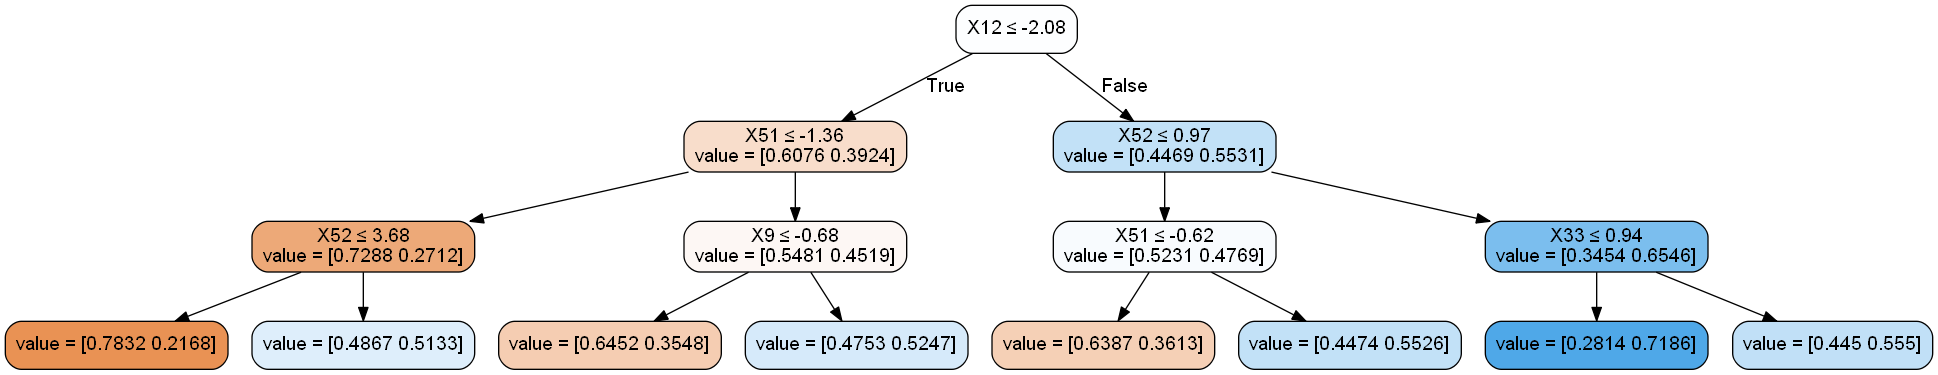

In [8]:
Image(graph2.create_png(features_name=feature_name))

In [24]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 5,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)
print(feature_name)

gbm = lgb.train(params, lgb_train, num_boost_round=5, valid_sets=lgb_test, feature_name=feature_name)

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99']
[1]	valid_0's binary_logloss: 0.689883
[2]	valid_0's binary_logloss: 0.686979
[3]	valid_0's binary_logloss: 0.684501
[4]	valid_0's binary_logloss: 0.681369
[5]	valid_0's binary_logloss: 0.678922


In [10]:
graph3 = BiGraph.from_lgboost(gbm)
HTML(graph3.df.to_html())

AssertionError: 

In [26]:
for _tree in gbm.dump_model(num_iteration=-1)['tree_info']:
    print(_tree['tree_index'])

0
1
2
3
4


In [48]:
import pickle
y = pickle.loads(pickle.dumps(x))
y[0][1] = 0.3
y

0                     [0.5000533333333333, 0.3]
1      [0.6076122893315056, 0.3923877106684945]
2      [0.4469102354675485, 0.5530897645324515]
3      [0.7287637698898409, 0.2712362301101591]
4      [0.5481000481000481, 0.4518999518999519]
5                                          None
6      [0.4866666666666667, 0.5133333333333333]
7      [0.6451612903225806, 0.3548387096774194]
8     [0.47526836455483057, 0.5247316354451694]
9      [0.5230790684702273, 0.4769209315297727]
10     [0.3453565120386725, 0.6546434879613275]
11    [0.6386539816772375, 0.36134601832276253]
12     [0.4473805677359797, 0.5526194322640203]
13     [0.2813740458015267, 0.7186259541984733]
14     [0.44497266460660806, 0.555027335393392]
Name: score, dtype: object

In [49]:
x

0     [0.5000533333333333, 0.49994666666666665]
1      [0.6076122893315056, 0.3923877106684945]
2      [0.4469102354675485, 0.5530897645324515]
3      [0.7287637698898409, 0.2712362301101591]
4      [0.5481000481000481, 0.4518999518999519]
5                                          None
6      [0.4866666666666667, 0.5133333333333333]
7      [0.6451612903225806, 0.3548387096774194]
8     [0.47526836455483057, 0.5247316354451694]
9      [0.5230790684702273, 0.4769209315297727]
10     [0.3453565120386725, 0.6546434879613275]
11    [0.6386539816772375, 0.36134601832276253]
12     [0.4473805677359797, 0.5526194322640203]
13     [0.2813740458015267, 0.7186259541984733]
14     [0.44497266460660806, 0.555027335393392]
Name: score, dtype: object

In [15]:
graph2 = graph.fit(X_train, y_train)
display(graph2.get_graph_info())

{'source': 'sklearn',
 'fitted': True,
 'objective': 'classification',
 'n_class': 2,
 'class_name': array([0, 1]),
 'features_name': None,
 'score_data': {'pred_score_key': 'pred_y',
  'color_score_key': 'pred_y',
  'population_cal_field_key': 'population_cal_field',
  'population_cal_field': {}},
 'n_features': 100}

In [16]:
HTML(graph2.df.to_html())

,depth,parent,child_left,child_right,type,data,score
0,0,0,1,2,0,"{'feature_data': {'split_feature': 12, 'split_criteria': '<=', 'split_threshold': -2.0825871229171753}}",{'pred_y': 0.49994666666666665}
1,1,0,3,4,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -1.3576117753982544}}",{'pred_y': 0.3923877106684945}
2,1,0,9,10,1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 0.9673941433429718}}",{'pred_y': 0.5530897645324515}
3,2,1,5,6,-1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 3.68274986743927}}",{'pred_y': 0.2712362301101591}
4,2,1,7,8,1,"{'feature_data': {'split_feature': 9, 'split_criteria': '<=', 'split_threshold': -0.6838884949684143}}",{'pred_y': 0.4518999518999519}
5,3,3,-1,-1,-1,None,{'pred_y': 0.21679160419790106}
6,3,3,-1,-1,1,None,{'pred_y': 0.5133333333333333}
7,3,4,-1,-1,-1,None,{'pred_y': 0.3548387096774194}
8,3,4,-1,-1,1,None,{'pred_y': 0.5247316354451694}
9,2,2,11,12,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -0.6225283443927765}}",{'pred_y': 0.4769209315297727}


In [17]:
a = graph.get_score('value').apply(lambda x: x[1]/(x[0] + x[1])).rename('a')
b = graph2.get_score('pred_y').rename('b')
c = pd.concat([a, b], axis=1)
c['c'] = c['a'] == c['b']
print(np.all(c['c']))
c

True


,a,b,c
0,0.499947,0.499947,True
1,0.392388,0.392388,True
2,0.553090,0.553090,True
3,0.271236,0.271236,True
4,0.451900,0.451900,True
5,0.216792,0.216792,True
6,0.513333,0.513333,True
7,0.354839,0.354839,True
8,0.524732,0.524732,True
9,0.476921,0.476921,True


In [21]:
print(np.any(np.isnan(graph2.predict(X_train))))
graph2.predict(X_train)

False


array([0.71862595, 0.36134602, 0.36134602, ..., 0.55261943, 0.2167916 ,
       0.2167916 ])

In [18]:
graph3 = graph2.compare_fit(X_test, y_test)
display(graph3.get_graph_info())

{'source': 'sklearn',
 'fitted': True,
 'objective': 'classification',
 'n_class': 2,
 'class_name': array([0, 1]),
 'features_name': None,
 'score_data': {'pred_score_key': 'train_y',
  'color_score_key': 'train_y',
  'population_cal_field_key': 'train_population_cal_field',
  'train_population_cal_field': {},
  'actual_population_cal_field_key': {}},
 'n_features': 100}

In [19]:
HTML(graph3.df.to_html())

,depth,parent,child_left,child_right,type,data,score
0,0,0,1,2,0,"{'feature_data': {'split_feature': 12, 'split_criteria': '<=', 'split_threshold': -2.0825871229171753}}","{'train_y': 0.49994666666666665, 'actual_y': 0.49992}"
1,1,0,3,4,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -1.3576117753982544}}","{'train_y': 0.3923877106684945, 'actual_y': 0.39685230024213075}"
2,1,0,9,10,1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 0.9673941433429718}}","{'train_y': 0.5530897645324515, 'actual_y': 0.5507765830346476}"
3,2,1,5,6,-1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 3.68274986743927}}","{'train_y': 0.2712362301101591, 'actual_y': 0.26071428571428573}"
4,2,1,7,8,1,"{'feature_data': {'split_feature': 9, 'split_criteria': '<=', 'split_threshold': -0.6838884949684143}}","{'train_y': 0.4518999518999519, 'actual_y': 0.4666666666666667}"
5,3,3,-1,-1,-1,None,"{'train_y': 0.21679160419790106, 'actual_y': 0.20623916811091855}"
6,3,3,-1,-1,1,None,"{'train_y': 0.5133333333333333, 'actual_y': 0.516260162601626}"
7,3,4,-1,-1,-1,None,"{'train_y': 0.3548387096774194, 'actual_y': 0.3722563652326602}"
8,3,4,-1,-1,1,None,"{'train_y': 0.5247316354451694, 'actual_y': 0.5342551854179761}"
9,2,2,11,12,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -0.6225283443927765}}","{'train_y': 0.4769209315297727, 'actual_y': 0.47540288379983037}"


In [25]:
graph3.get_score().apply(pd.Series)

,train_y,actual_y
0,0.499947,0.499920
1,0.392388,0.396852
2,0.553090,0.550777
3,0.271236,0.260714
4,0.451900,0.466667
5,0.216792,0.206239
6,0.513333,0.516260
7,0.354839,0.372256
8,0.524732,0.534255
9,0.476921,0.475403


In [27]:
graph2.compare_fit(X_train, y_train).get_score().apply(pd.Series)

,train_y,actual_y
0,0.499947,0.499947
1,0.392388,0.392388
2,0.553090,0.553090
3,0.271236,0.271236
4,0.451900,0.451900
5,0.216792,0.216792
6,0.513333,0.513333
7,0.354839,0.354839
8,0.524732,0.524732
9,0.476921,0.476921


In [22]:
graph2 = BiGraph.from_sklearn_tree(reg_tree)
display(graph2.get_graph_info())
HTML(graph2.df.to_html())

{'source': 'sklearn',
 'fitted': True,
 'objective': 'regression',
 'n_class': None,
 'class_name': None,
 'features_name': None,
 'score_data': {'pred_score_key': 'value', 'color_score_key': 'value'},
 'n_features': 100}

,depth,parent,child_left,child_right,type,data,score
0,0,0,1,2,0,"{'feature_data': {'split_feature': 12, 'split_criteria': '<=', 'split_threshold': -2.0825871229171753}}","{'mse': 0.24999999715555554, 'sample': 37500, 'value': 0.49994666666666665}"
1,1,0,3,4,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -1.3576117753982544}}","{'mse': 0.23841959518483236, 'sample': 12401, 'value': 0.3923877106684945}"
2,1,0,5,6,1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 0.9673941433429718}}","{'mse': 0.24718147690188885, 'sample': 25099, 'value': 0.5530897645324515}"
3,2,1,-1,-1,-1,None,"{'mse': 0.19766713758578794, 'sample': 4085, 'value': 0.2712362301101591}"
4,2,1,-1,-1,1,None,"{'mse': 0.24768638537277307, 'sample': 8316, 'value': 0.4518999518999519}"
5,2,2,-1,-1,-1,None,"{'mse': 0.24946735659854657, 'sample': 14342, 'value': 0.4769209315297727}"
6,2,2,-1,-1,1,None,"{'mse': 0.22608539163115476, 'sample': 10757, 'value': 0.6546434879613275}"


In [ ]:
reg_tree.tree_.value[0]

In [ ]:
type(reg_tree) in [DecisionTreeClassifier, DecisionTreeRegressor]

In [ ]:
HTML(graph2.subgraph(2).reindex_graph().df.to_html())

In [ ]:
HTML(graph2.convert_to_leaf(2).reindex_graph().df.to_html())

In [ ]:
HTML(graph2.df.to_html())

In [ ]:
import numpy as np
from TreeUtils.utils.utils import flatten_list

In [ ]:
x = {}
for i in range(10000):
    x[i] = np.random.normal(size=np.random.randint(10))

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)
print(feature_name)

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 5,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}
gbm = lgb.train(params, lgb_train, num_boost_round=5, valid_sets=lgb_test, feature_name=feature_name)
categorical_feature=

In [ ]:
gbm.dump_model()['pandas_categorical']

In [ ]:
gbm.dump_model()['pandas_categorical']

In [ ]:
HTML(graph2.subgraph(2).reindex_graph().df.to_html())

In [ ]:
HTML(graph2.convert_to_leaf(2).reindex_graph().df.to_html())

In [ ]:
HTML(graph2.df.to_html())

In [ ]:
import numpy as np
from TreeUtils.utils.utils import flatten_list

In [ ]:
x = {}
for i in range(10000):
    x[i] = np.random.normal(size=np.random.randint(10))

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)
print(feature_name)

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 5,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}
gbm = lgb.train(params, lgb_train, num_boost_round=5, valid_sets=lgb_test, feature_name=feature_name)
categorical_feature=

In [ ]:
gbm.dump_model()['pandas_categorical']